### Imports for this Notebook

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import StratifiedShuffleSplit
from gensim.models.doc2vec import TaggedDocument
from gensim.models.doc2vec import Doc2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.neural_network import MLPClassifier, BernoulliRBM
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

### Read data

In [25]:
# path to the train data file
INDATA_LOCATION = 'C:/Users/sharm/Desktop/Dat5Melb/Final_Project/Datasets/train/train.csv'

# utility definitions for easier handling of the dataset column names
TEXT_COLUMN = 'comment_text'
CLASS_TOXIC, CLASS_SEVER_TOXIC, CLASS_OBSCENE, CLASS_THREAT, CLASS_INSULT, \
    CLASS_IDENTITY_HATE = ["toxic", "severe_toxic", "obscene", "threat", \
                           "insult", "identity_hate"]
CLASSES = [CLASS_TOXIC, CLASS_SEVER_TOXIC, CLASS_OBSCENE, CLASS_THREAT, CLASS_INSULT, CLASS_IDENTITY_HATE]

def read_data(filename):
    return pd.read_csv(filename) 

# read the comments and associated classification data 
dataDf = read_data(INDATA_LOCATION)

In [38]:
cv = CountVectorizer(binary=False,
                     stop_words='english',
                     min_df=2)

docs = cv.fit_transform(dataDf['comment_text'])

# Build a mapping of numerical ID to word
id2word = dict(enumerate(cv.get_feature_names()))

In [39]:
id2word

{0: u'00',
 1: u'000',
 2: u'0000',
 3: u'00000',
 4: u'000000',
 5: u'0000z',
 6: u'0001',
 7: u'0003',
 8: u'000_bucks',
 9: u'000ft',
 10: u'000s',
 11: u'000th',
 12: u'001',
 13: u'0015',
 14: u'002',
 15: u'003',
 16: u'004',
 17: u'0049703',
 18: u'005',
 19: u'006',
 20: u'007',
 21: u'008',
 22: u'009',
 23: u'00am',
 24: u'00pm',
 25: u'00utc',
 26: u'01',
 27: u'010',
 28: u'0100',
 29: u'0108',
 30: u'011',
 31: u'0110',
 32: u'012',
 33: u'013',
 34: u'014',
 35: u'016',
 36: u'01w',
 37: u'02',
 38: u'0200',
 39: u'0207',
 40: u'0208hrs',
 41: u'021',
 42: u'023',
 43: u'0230',
 44: u'0231130104',
 45: u'026',
 46: u'027',
 47: u'0287221',
 48: u'03',
 49: u'034',
 50: u'039',
 51: u'0393322521',
 52: u'04',
 53: u'040',
 54: u'0400',
 55: u'041',
 56: u'0416',
 57: u'0422',
 58: u'0429hrs',
 59: u'046',
 60: u'048',
 61: u'049',
 62: u'0495',
 63: u'05',
 64: u'050',
 65: u'051211',
 66: u'053',
 67: u'055',
 68: u'0576',
 69: u'058',
 70: u'059',
 71: u'05mm',
 72: u'06

In [46]:
from gensim.models.ldamodel import LdaModel
from gensim.matutils import Sparse2Corpus

# First we convert our word-matrix into gensim's format
corpus = Sparse2Corpus(docs, documents_columns = False)

# Then we fit an LDA model
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=50)

In [47]:
num_topics = 6
num_words_per_topic = 3
for ti, topic in enumerate(lda_model.show_topics(num_topics = num_topics, num_words = num_words_per_topic)):
    print("Topic: %d" % (ti))
    print (topic)
    print()

Topic: 0
(24, u'0.018*"al" + 0.017*"talking" + 0.017*"band"')
()
Topic: 1
(19, u'0.028*"000" + 0.024*"yes" + 0.020*"infobox"')
()
Topic: 2
(14, u'0.097*"hate" + 0.063*"suck" + 0.056*"game"')
()
Topic: 3
(42, u'0.076*"article" + 0.068*"deletion" + 0.042*"deleted"')
()
Topic: 4
(7, u'0.021*"white" + 0.018*"character" + 0.017*"song"')
()
Topic: 5
(33, u'0.055*"stupid" + 0.041*"wrong" + 0.032*"right"')
()


In [62]:
dataDf['comment_text'].str.lower()

0         explanation\nwhy the edits made under my usern...
1         d'aww! he matches this background colour i'm s...
2         hey man, i'm really not trying to edit war. it...
3         "\nmore\ni can't make any real suggestions on ...
4         you, sir, are my hero. any chance you remember...
5         "\n\ncongratulations from me as well, use the ...
6              cocksucker before you piss around on my work
7         your vandalism to the matt shirvington article...
8         sorry if the word 'nonsense' was offensive to ...
9         alignment on this subject and which are contra...
10        "\nfair use rationale for image:wonju.jpg\n\nt...
11        bbq \n\nbe a man and lets discuss it-maybe ove...
12        hey... what is it..\n@ | talk .\nwhat is it......
13        before you start throwing accusations and warn...
14        oh, and the girl above started her arguments w...
15        "\n\njuelz santanas age\n\nin 2002, juelz sant...
16        bye! \n\ndon't look, come or t

In [50]:
import sys

class PorterStemmer:

    def __init__(self):
        """The main part of the stemming algorithm starts here.
        b is a buffer holding a word to be stemmed. The letters are in b[k0],
        b[k0+1] ... ending at b[k]. In fact k0 = 0 in this demo program. k is
        readjusted downwards as the stemming progresses. Zero termination is
        not in fact used in the algorithm.

        Note that only lower case sequences are stemmed. Forcing to lower case
        should be done before stem(...) is called.
        """

        self.b = ""  # buffer for word to be stemmed
        self.k = 0
        self.k0 = 0
        self.j = 0   # j is a general offset into the string

    def cons(self, i):
        """cons(i) is TRUE <=> b[i] is a consonant."""
        if self.b[i] == 'a' or self.b[i] == 'e' or self.b[i] == 'i' or self.b[i] == 'o' or self.b[i] == 'u':
            return 0
        if self.b[i] == 'y':
            if i == self.k0:
                return 1
            else:
                return (not self.cons(i - 1))
        return 1

    def m(self):
        """m() measures the number of consonant sequences between k0 and j.
        if c is a consonant sequence and v a vowel sequence, and <..>
        indicates arbitrary presence,

           <c><v>       gives 0
           <c>vc<v>     gives 1
           <c>vcvc<v>   gives 2
           <c>vcvcvc<v> gives 3
           ....
        """
        n = 0
        i = self.k0
        while 1:
            if i > self.j:
                return n
            if not self.cons(i):
                break
            i = i + 1
        i = i + 1
        while 1:
            while 1:
                if i > self.j:
                    return n
                if self.cons(i):
                    break
                i = i + 1
            i = i + 1
            n = n + 1
            while 1:
                if i > self.j:
                    return n
                if not self.cons(i):
                    break
                i = i + 1
            i = i + 1

    def vowelinstem(self):
        """vowelinstem() is TRUE <=> k0,...j contains a vowel"""
        for i in range(self.k0, self.j + 1):
            if not self.cons(i):
                return 1
        return 0

    def doublec(self, j):
        """doublec(j) is TRUE <=> j,(j-1) contain a double consonant."""
        if j < (self.k0 + 1):
            return 0
        if (self.b[j] != self.b[j-1]):
            return 0
        return self.cons(j)

    def cvc(self, i):
        """cvc(i) is TRUE <=> i-2,i-1,i has the form consonant - vowel - consonant
        and also if the second c is not w,x or y. this is used when trying to
        restore an e at the end of a short  e.g.

           cav(e), lov(e), hop(e), crim(e), but
           snow, box, tray.
        """
        if i < (self.k0 + 2) or not self.cons(i) or self.cons(i-1) or not self.cons(i-2):
            return 0
        ch = self.b[i]
        if ch == 'w' or ch == 'x' or ch == 'y':
            return 0
        return 1

    def ends(self, s):
        """ends(s) is TRUE <=> k0,...k ends with the string s."""
        length = len(s)
        if s[length - 1] != self.b[self.k]: # tiny speed-up
            return 0
        if length > (self.k - self.k0 + 1):
            return 0
        if self.b[self.k-length+1:self.k+1] != s:
            return 0
        self.j = self.k - length
        return 1

    def setto(self, s):
        """setto(s) sets (j+1),...k to the characters in the string s, readjusting k."""
        length = len(s)
        self.b = self.b[:self.j+1] + s + self.b[self.j+length+1:]
        self.k = self.j + length

    def r(self, s):
        """r(s) is used further down."""
        if self.m() > 0:
            self.setto(s)

    def step1ab(self):
        """step1ab() gets rid of plurals and -ed or -ing. e.g.

           caresses  ->  caress
           ponies    ->  poni
           ties      ->  ti
           caress    ->  caress
           cats      ->  cat

           feed      ->  feed
           agreed    ->  agree
           disabled  ->  disable

           matting   ->  mat
           mating    ->  mate
           meeting   ->  meet
           milling   ->  mill
           messing   ->  mess

           meetings  ->  meet
        """
        if self.b[self.k] == 's':
            if self.ends("sses"):
                self.k = self.k - 2
            elif self.ends("ies"):
                self.setto("i")
            elif self.b[self.k - 1] != 's':
                self.k = self.k - 1
        if self.ends("eed"):
            if self.m() > 0:
                self.k = self.k - 1
        elif (self.ends("ed") or self.ends("ing")) and self.vowelinstem():
            self.k = self.j
            if self.ends("at"):   self.setto("ate")
            elif self.ends("bl"): self.setto("ble")
            elif self.ends("iz"): self.setto("ize")
            elif self.doublec(self.k):
                self.k = self.k - 1
                ch = self.b[self.k]
                if ch == 'l' or ch == 's' or ch == 'z':
                    self.k = self.k + 1
            elif (self.m() == 1 and self.cvc(self.k)):
                self.setto("e")

    def step1c(self):
        """step1c() turns terminal y to i when there is another vowel in the stem."""
        if (self.ends("y") and self.vowelinstem()):
            self.b = self.b[:self.k] + 'i' + self.b[self.k+1:]

    def step2(self):
        """step2() maps double suffices to single ones.
        so -ization ( = -ize plus -ation) maps to -ize etc. note that the
        string before the suffix must give m() > 0.
        """
        if self.b[self.k - 1] == 'a':
            if self.ends("ational"):   self.r("ate")
            elif self.ends("tional"):  self.r("tion")
        elif self.b[self.k - 1] == 'c':
            if self.ends("enci"):      self.r("ence")
            elif self.ends("anci"):    self.r("ance")
        elif self.b[self.k - 1] == 'e':
            if self.ends("izer"):      self.r("ize")
        elif self.b[self.k - 1] == 'l':
            if self.ends("bli"):       self.r("ble") # --DEPARTURE--
            # To match the published algorithm, replace this phrase with
            #   if self.ends("abli"):      self.r("able")
            elif self.ends("alli"):    self.r("al")
            elif self.ends("entli"):   self.r("ent")
            elif self.ends("eli"):     self.r("e")
            elif self.ends("ousli"):   self.r("ous")
        elif self.b[self.k - 1] == 'o':
            if self.ends("ization"):   self.r("ize")
            elif self.ends("ation"):   self.r("ate")
            elif self.ends("ator"):    self.r("ate")
        elif self.b[self.k - 1] == 's':
            if self.ends("alism"):     self.r("al")
            elif self.ends("iveness"): self.r("ive")
            elif self.ends("fulness"): self.r("ful")
            elif self.ends("ousness"): self.r("ous")
        elif self.b[self.k - 1] == 't':
            if self.ends("aliti"):     self.r("al")
            elif self.ends("iviti"):   self.r("ive")
            elif self.ends("biliti"):  self.r("ble")
        elif self.b[self.k - 1] == 'g': # --DEPARTURE--
            if self.ends("logi"):      self.r("log")
        # To match the published algorithm, delete this phrase

    def step3(self):
        """step3() dels with -ic-, -full, -ness etc. similar strategy to step2."""
        if self.b[self.k] == 'e':
            if self.ends("icate"):     self.r("ic")
            elif self.ends("ative"):   self.r("")
            elif self.ends("alize"):   self.r("al")
        elif self.b[self.k] == 'i':
            if self.ends("iciti"):     self.r("ic")
        elif self.b[self.k] == 'l':
            if self.ends("ical"):      self.r("ic")
            elif self.ends("ful"):     self.r("")
        elif self.b[self.k] == 's':
            if self.ends("ness"):      self.r("")

    def step4(self):
        """step4() takes off -ant, -ence etc., in context <c>vcvc<v>."""
        if self.b[self.k - 1] == 'a':
            if self.ends("al"): pass
            else: return
        elif self.b[self.k - 1] == 'c':
            if self.ends("ance"): pass
            elif self.ends("ence"): pass
            else: return
        elif self.b[self.k - 1] == 'e':
            if self.ends("er"): pass
            else: return
        elif self.b[self.k - 1] == 'i':
            if self.ends("ic"): pass
            else: return
        elif self.b[self.k - 1] == 'l':
            if self.ends("able"): pass
            elif self.ends("ible"): pass
            else: return
        elif self.b[self.k - 1] == 'n':
            if self.ends("ant"): pass
            elif self.ends("ement"): pass
            elif self.ends("ment"): pass
            elif self.ends("ent"): pass
            else: return
        elif self.b[self.k - 1] == 'o':
            if self.ends("ion") and (self.b[self.j] == 's' or self.b[self.j] == 't'): pass
            elif self.ends("ou"): pass
            # takes care of -ous
            else: return
        elif self.b[self.k - 1] == 's':
            if self.ends("ism"): pass
            else: return
        elif self.b[self.k - 1] == 't':
            if self.ends("ate"): pass
            elif self.ends("iti"): pass
            else: return
        elif self.b[self.k - 1] == 'u':
            if self.ends("ous"): pass
            else: return
        elif self.b[self.k - 1] == 'v':
            if self.ends("ive"): pass
            else: return
        elif self.b[self.k - 1] == 'z':
            if self.ends("ize"): pass
            else: return
        else:
            return
        if self.m() > 1:
            self.k = self.j

    def step5(self):
        """step5() removes a final -e if m() > 1, and changes -ll to -l if
        m() > 1.
        """
        self.j = self.k
        if self.b[self.k] == 'e':
            a = self.m()
            if a > 1 or (a == 1 and not self.cvc(self.k-1)):
                self.k = self.k - 1
        if self.b[self.k] == 'l' and self.doublec(self.k) and self.m() > 1:
            self.k = self.k -1

    def stem(self, p, i, j):
        """In stem(p,i,j), p is a char pointer, and the string to be stemmed
        is from p[i] to p[j] inclusive. Typically i is zero and j is the
        offset to the last character of a string, (p[j+1] == '\0'). The
        stemmer adjusts the characters p[i] ... p[j] and returns the new
        end-point of the string, k. Stemming never increases word length, so
        i <= k <= j. To turn the stemmer into a module, declare 'stem' as
        extern, and delete the remainder of this file.
        """
        # copy the parameters into statics
        self.b = p
        self.k = j
        self.k0 = i
        if self.k <= self.k0 + 1:
            return self.b # --DEPARTURE--

        # With this line, strings of length 1 or 2 don't go through the
        # stemming process, although no mention is made of this in the
        # published algorithm. Remove the line to match the published
        # algorithm.

        self.step1ab()
        self.step1c()
        self.step2()
        self.step3()
        self.step4()
        self.step5()
        return self.b[self.k0:self.k+1]


# if __name__ == '__main__':
#     p = PorterStemmer()
#     if len(sys.argv) > 1:
#         for f in sys.argv[1:]:
#             infile = open(f, 'r')
#             while 1:
#                 output = ''
#                 word = ''
#                 line = infile.readline()
#                 if line == '':
#                     break
#                 for c in line:
#                     if c.isalpha():
#                         word += c.lower()
#                     else:
#                         if word:
#                             output += p.stem(word, 0,len(word)-1)
#                             word = ''
#                         output += c.lower()
#                 print output,
#             infile.close()

In [66]:
# dataDf['comment_text'] = dataDf['comment_text'].str.lower()
p = PorterStemmer()
p.stem(dataDf['comment_text'],0,len(dataDf)-1)

0         explanation\nwhy the edits made under my usern...
1         d'aww! he matches this background colour i'm s...
2         hey man, i'm really not trying to edit war. it...
3         "\nmore\ni can't make any real suggestions on ...
4         you, sir, are my hero. any chance you remember...
5         "\n\ncongratulations from me as well, use the ...
6              cocksucker before you piss around on my work
7         your vandalism to the matt shirvington article...
8         sorry if the word 'nonsense' was offensive to ...
9         alignment on this subject and which are contra...
10        "\nfair use rationale for image:wonju.jpg\n\nt...
11        bbq \n\nbe a man and lets discuss it-maybe ove...
12        hey... what is it..\n@ | talk .\nwhat is it......
13        before you start throwing accusations and warn...
14        oh, and the girl above started her arguments w...
15        "\n\njuelz santanas age\n\nin 2002, juelz sant...
16        bye! \n\ndon't look, come or t

### Basic data characteristics

In [26]:
def basic_characteristics(df):
    print('Number of data points: %d' %len(df))
    for klass in CLASSES:
        print('Number data points of type %s: %d' %(klass, len(df[df[klass]==1])))        
basic_characteristics(dataDf)

Number of data points: 159571
Number data points of type toxic: 15294
Number data points of type severe_toxic: 1595
Number data points of type obscene: 8449
Number data points of type threat: 478
Number data points of type insult: 7877
Number data points of type identity_hate: 1405


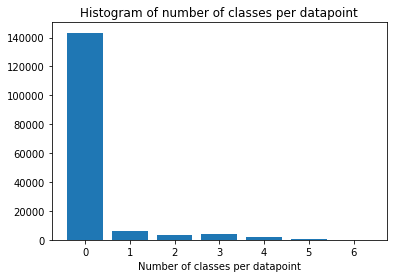

In [27]:
labels, counts = np.unique(dataDf[CLASSES].sum(axis=1), return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_title('Histogram of number of classes per datapoint')
plt.gca().set_xlabel('Number of classes per datapoint')
plt.gca().set_xticks(labels)
plt.show()

### Embed text in vector space

We use a simple count based vectorizer to embed the comment text into vector space in preparation for building classification models.

In [28]:
class CommentVectorizer:
    def __init__(self):
        self._vectorizers = []
        
    def get_count_vectorizer(self, max_features = 1000, ngram_range = (1, 2), 
                             stop_words = 'english', binary = True):
        """
        Initializes a count vectorizer with parameters set by the user and 
        returns an index in the internal vector array where the vectorizer
        has been placed. We dont want any external entity manipulating the
        vectorizer state directly.
        """
        self._vectorizers.append(CountVectorizer(max_features = max_features, 
                                                 ngram_range = ngram_range, 
                                                 stop_words = stop_words,
                                                 binary = binary))
        return len(self._vectorizers) - 1
    
    def get_tdidf_vectorizer(self, max_features = 5000, use_idf = True):
        self._vectorizers.append(TfidfVectorizer(max_df=0.7, max_features=max_features,
                                 min_df=2, stop_words='english',
                                 use_idf=use_idf))
        return len(self._vectorizers) - 1
    
    def doc2vec_fit_transform(self, sentences):
        """
        Method for building a doc2vec model. Unfortunately it does not follow the nice fit/transform
        pattern of the scikit models.
        """
        documents = map(lambda i: TaggedDocument(sentences[i].split(), [i]),
                        range(len(sentences)))
        model = Doc2Vec(documents, size=100, window=8, min_count=0, workers=8)
        return map(lambda x: model.docvecs[x], range(len(sentences)))
    
    def _exists(self, vectorizer):
        """
        Checks if the vectorizer index provided points to a valid vectorizer.
        """
        if vectorizer < 0 or len(self._vectorizers) <= vectorizer:
            raise Exception('Vectorizer index out of bound.')
            
        if self._vectorizers[vectorizer] == None:
            raise Exception('Vectorizer not initialized.')
            
        pass
        
    def fit(self, comments = [], vectorizer = -1):
        self._exists(vectorizer)
        self._vectorizers[vectorizer].fit(comments)
        
    def transform(self, comments, vectorizer):
        self._exists(vectorizer)
        return self._vectorizers[vectorizer].transform(comments)    

In [29]:
# initialize a count vectorizer for this experiment    
commentVectorizer = CommentVectorizer()
vectorizer = commentVectorizer.get_tdidf_vectorizer()
commentVectorizer.fit(dataDf[TEXT_COLUMN], vectorizer)

# embed comments into vector space
commentVectors = commentVectorizer.transform(dataDf[TEXT_COLUMN], vectorizer)
# commentVectors = np.array(commentVectorizer.doc2vec_fit_transform(dataDf[TEXT_COLUMN]))

Text(0.5,1,u'Scatter plot of the comment vectors (reduced)')

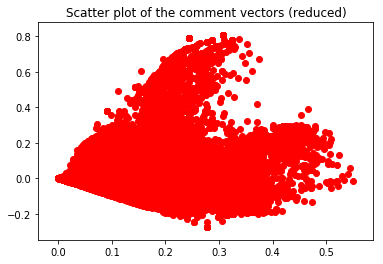

In [12]:
coords = TruncatedSVD(n_components=2).fit_transform(commentVectors)
plt.scatter(coords[:,0], coords[:,1], color='red' )
plt.title('Scatter plot of the comment vectors (reduced)')

### Create modeling and evaluation sets

In [13]:
# shuffle and split the dataset stratified by the number of classifications of a data point
# for balancing across resulting modeling and evaluation datasets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(np.zeros(len(dataDf)), dataDf[CLASSES].sum(axis=1)):
    pass

# modeling dataset
modeling_vectors = commentVectors[train_index]
modeling_classes = dataDf[CLASSES].loc[train_index]
print('Modeling data size: %d' %len(modeling_classes))
basic_characteristics(modeling_classes)

# evaluation dataset
evaluation_vectors = commentVectors[test_index]
evaluation_classes = dataDf[CLASSES].loc[test_index]
print('Evaluation data size: %d' %len(evaluation_classes))
basic_characteristics(evaluation_classes)

Modeling data size: 127656
Number of data points: 127656
Number data points of type toxic: 12219
Number data points of type severe_toxic: 1280
Number data points of type obscene: 6765
Number data points of type threat: 386
Number data points of type insult: 6314
Number data points of type identity_hate: 1115
Evaluation data size: 31915
Number of data points: 31915
Number data points of type toxic: 3075
Number data points of type severe_toxic: 315
Number data points of type obscene: 1684
Number data points of type threat: 92
Number data points of type insult: 1563
Number data points of type identity_hate: 290


### Build classification model

In [ ]:
X = modeling_vectors
y = modeling_classes


rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [5, 10],
    'max_features': ['auto', 'sqrt', 'log2']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X, y)
print CV_rfc.best_params_

In [ ]:
SVC(C=1.0, cache_size=50, class_weight='balanced', decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf', max_iter=-1, probability=True, random_state=1, shrinking=True, tol=0.001)
RandomForestClassifier(n_estimators = 150, class_weight = 'balanced', n_jobs=-1, criterion="entropy")

In [23]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
 
X = modeling_vectors
Y = modeling_classes["toxic"]
names = commentVectors[train_index]
 
#use linear regression as the model
lr = LinearRegression()
#rank all features, i.e continue the elimination until the last one
rfe = RFE(lr, n_features_to_select=1)
rfe.fit(X,Y)
 
print "Features sorted by their rank:"
print sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names))

Features sorted by their rank:
[(1.0, <1x5000 sparse matrix of type '<type 'numpy.float64'>'
	with 7 stored elements in Compressed Sparse Row format>), (2.0, <1x5000 sparse matrix of type '<type 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>), (3.0, <1x5000 sparse matrix of type '<type 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>), (4.0, <1x5000 sparse matrix of type '<type 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>), (5.0, <1x5000 sparse matrix of type '<type 'numpy.float64'>'
	with 14 stored elements in Compressed Sparse Row format>), (6.0, <1x5000 sparse matrix of type '<type 'numpy.float64'>'
	with 11 stored elements in Compressed Sparse Row format>), (7.0, <1x5000 sparse matrix of type '<type 'numpy.float64'>'
	with 17 stored elements in Compressed Sparse Row format>), (8.0, <1x5000 sparse matrix of type '<type 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>), (9.0

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier

class ExtendedMultiOutputClassifier(MultiOutputClassifier):
    def transform(self, X):
        """
        Add a transform method to the classifier because it is mandatory for steps of a pipeline
        to provide fit and transform methods.
        """
        _o = self.predict_proba(X)
        return np.concatenate(_o, axis=1)

moc = ExtendedMultiOutputClassifier(SVC(C=1e-3, cache_size=10, decision_function_shape='ovo', kernel='linear', max_iter=7000, probability=True, random_state=1, tol=0.001))
nnc = MLPClassifier(solver='sgd', activation='logistic', learning_rate='adaptive', momentum=0.9, alpha=1e-2, hidden_layer_sizes=(150, 150), random_state=1, tol=1e-15)
# specify the order in which pipeline should execute the classifiers/estimators
clf = Pipeline([('moc_rf', moc), ('nnc', nnc)])
# fit all the transforms one after the other and transform the data, then fit the transformed data using the final estimator.
clf.fit(modeling_vectors, modeling_classes)
# rudimentary test
predictions = clf.predict_proba(modeling_vectors)

# calculate MSE (mean squared error). note np.dot on full matrix gives 
# memmory error hence the slow work around
d = predictions - modeling_classes
sq_difs = map(lambda x: np.dot(x, x.T), d.as_matrix())
print('MSE: %f' %(np.sum(sq_difs) * 1.0 / len(d))) 

### Evaluation

In [ ]:
predictions = clf.predict_proba(evaluation_vectors)

# MSE
d = predictions - evaluation_classes
sq_difs = map(lambda x: np.dot(x, x.T), d.as_matrix())
print('MSE: %f' %(np.sum(sq_difs) * 1.0 / len(d)))

### Read in test dataset

In [ ]:
testdf = pd.read_csv('C:/Users/sharm/Desktop/Dat5Melb/Final_Project/Datasets/test1/test.csv')
testdf.id = testdf.id.astype(basestring)
testdf.head()

In [ ]:
testdf.info()

### Embded test dataset

In [ ]:
# embed comments into vector space
testcommentVectors = commentVectorizer.transform(testdf[TEXT_COLUMN], vectorizer)
testcommentVectors

### Predict final probabilities

In [ ]:
testpredictions = clf.predict_proba(testcommentVectors)
testpdf = pd.DataFrame(data=testpredictions)

In [ ]:
submissiondf = testpdf.join(testdf['id'], how='left')
submissiondf = submissiondf[['id',0,1,2,3,4,5]]
submissiondf.columns = ["id", "toxic", "severe_toxic", "obscene", "threat","insult", "identity_hate"]
submissiondf.head()

In [ ]:
# submissiondf.to_csv('submission.csv', index=False)

def manual_write(submissiondf,filename):
    of = file(filename, 'w')
    of.write('%s\n' %','.join(submissiondf.columns))
    for idx in range(len(submissiondf)):
        of.write('%s\n' %','.join(map(str, submissiondf.iloc[idx].tolist())))
    of.close()

manual_write(submissiondf, 'submission2.csv')

In [ ]:
submissiondf.info()